In [ ]:
%matplotlib inline

#[Откройте задание в Google Colab](https://colab.research.google.com/drive/1NjBTFw753I1q5XZLA1PuAkq_fE7aTgyL?usp=sharing)

Выберите "Среду выполнения" - GPU


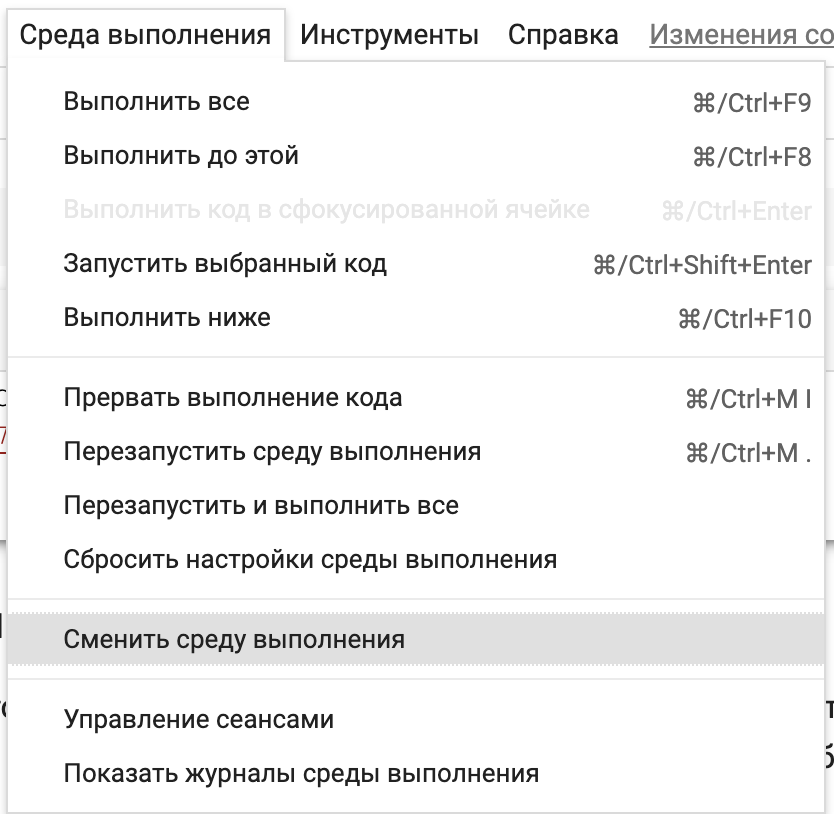

Дообучение моделей torchvision
------------------------------

В данном задании вам предстоит аккуратно проделать все шаги лабораторной работы и сохранить полученные веса модели в файл (`'final_model.pt'`), который вы и будете сдавать в качестве результата данной работы.

Некоторые шаги уже выполнены за вас, в других вам будет необходимо выполнить небольшие задания.


https://pytorch.org/docs/stable/torchvision/models.html - обучены на ImageNet

Предстоит дообучить всю модель и оставить параметр для обучения только финальных слоев (извлечение признаков).

По шагам:
-  инициализация предобученной модели
-  изменение финальных слоёв, изменение формы под целевой набор данных
-  определяем, как будем менять модель (всю или нет)
-  запуск обучения


In [ ]:
from __future__ import print_function, division

import time
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

Данные
------

Будем использовать набор данных *hymenoptera_data*: https://download.pytorch.org/tutorial/hymenoptera_data.zip.
В данных присутствует два класса - пчелы и муравьи.
Для обращения с даннымии будем пользоваться ImageFolder - https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder

В качестве модели будем использовать vgg11_bn - VGG11 обученная с применением batch normalization

Среди прочих параметров:
batch_size - размер батча, num_classes - количество классов в данных, num_epochs - количество эпох обучения, finetune - флаг о дообучении финальных слоёв




In [ ]:
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! mkdir data
! unzip hymenoptera_data.zip

--2020-11-15 18:25:45--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.153.31, 13.224.153.12, 13.224.153.85, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.153.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  1015KB/s    in 47s     

2020-11-15 18:26:33 (990 KB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data

In [ ]:
! mv hymenoptera_data data/
! ls ./data

hymenoptera_data


In [ ]:
data_dir = "./data/hymenoptera_data" # путь до данных
num_classes = 2                      # количество классов в новых данных

batch_size = 8                       # размер блока данных
num_epochs = 5                       # количество эпох обучения
feature_extract = True               # использовать извелчение признаков

Обучение модели
---------------

А также опишем вспомогательную функцию для проставления параметра слоёв (об этом далее).

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    start = time.time()
    _hist = []
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            _loss, _acc = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                _loss += loss.item() * inputs.size(0)
                _acc += torch.sum(preds == labels.data)

            epoch_loss = _loss / len(dataloaders[phase].dataset)
            epoch_acc = _acc.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.6f} Acc: {:.6f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                _hist.append(epoch_acc)
                if epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - start
    print('Обучение завершено: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Validation: лучшее значение Accuracy: {:6f}'.format(best_acc))

    model.load_state_dict(best_model)
    return model, _hist


def set_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

Иницииализация и изменение моделей
-----------------------------------

Подробнее тут - https://pytorch.org/docs/stable/torchvision/models.html

В этом блоке мы меняем финальный слой модели. Этот процесс сложно автоматизируется, так как каждая модель обладает своими характеристиками. Последний слой CNN модели (зачастую полносвязный) имеет столько же выходов, сколько и классов в данных. Все модели в torchvision обучены на Imagenet, поэтому финальный слой имеет размер 1000.

Наша цель - изменить последний слой так, чтобы число входов не изменилось, а число выходов соответствовало новому набору данных.

Отметим важную деталь, отличающую полное дообучение от извлечение признаков (feature-extraction, дообучение финальных слоёв). В отличие от первого случая, в случае извлечения признаков мы хотим изменять только последний слой, таким образом не вычислять градиенты на предыдущих слоях, для чего мы выставляем параметр этих слоёв `required_grad=False`. По-умолчанию этот параметр равен True (в том числе новый созданный слой, но его мы хотим изменять, поэтому не меняем параметр для этого слоя).

VGG
---

Подробнее о модели можно почитать тут - https://arxiv.org/pdf/1409.1556.pdf

В библиотеке torchvision существует 8 версий предобученной модели VGG разных размеров и слоями для нормализации блоков (batch-normalization).
Мы будем использовать VGG-11 с нормализацией блоков.

В описании модели можно увидеть следующее: классификатор (голова модели) содержит финальный слой - линейный с 4096 входными параметрами и 1000 выходными.
```
   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
```
Для изменения этого слоя мы можем воспользоваться следующим кодом:

`model.classifier[6] = nn.Linear(4096,num_classes)`

Мы обращаемся к блоку классификатора и меняем шестой блок (последний слой) в последовательности.

In [ ]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.vgg11_bn(pretrained=use_pretrained)
    
    set_requires_grad(model_ft, feature_extract)

    num_ftrs = model_ft.classifier[6].in_features

    #
    #
    # вставьте здесь замену слоя
    model_ft.classifier[6] = nn.Linear(num_ftrs, 2)
    #
    #

    input_size = 224
    
    return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(k

Загрузка данных
---------

Теперь, зная параметры входных данных, мы можем инициализировать считывание данных
Заметим, что модели обучены с некоторыми значениями нормализации, подробнее - https://pytorch.org/docs/master/torchvision/models.html




In [ ]:
# нормализация данных
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x),
                            data_transforms[x])
    for x in ['train', 'val']
}
dataloaders_dict = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                   shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Создаём оптимизатор
--------------------

Теперь у нас есть модель и данные, последнее что нам осталось - создать оптимизатор (`optimizer`), который будет пересчитывать только те параметры, которые мы хотим. Мы уже корректно настроили `requires_grad` параметр в прошлом пункте (новый созданный слой по-умолчанию проставлен в `True`, остальные мы проставили в `False` в случае, если хотим использовать извлечение параметров).

Теперь нам необходимо передать эти (и только эти) параметры в SGD для оптимизации.



In [ ]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters() # по-умолчанию возьмём все параметры
print("Параметры для обновления при обучении:")

if feature_extract:
    # только последний слой, обновляем список
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    # все параметры, просто выводим
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.002, momentum=0.9)

Параметры для обновления при обучении:
	 classifier.6.weight
	 classifier.6.bias


Обучение и валидация
--------------------------------

Теперь нам надо установить, как мы будем считать ошибку (loss), и запустить обучение и подсчёт для того количества эпох, которые мы выставили в самом начале. Обучение на CPU может занять некоторое время (в зависимости от модели), кроме того learning rate изначально неоптимален и может потребовать подбора.




In [ ]:
# функция подсчёта ошибки
criterion = nn.CrossEntropyLoss()

# обучение
# вызовите функцию train_model со всеми необходимыми параметрами:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
train Loss: 0.468339 Acc: 0.754098
val Loss: 0.234212 Acc: 0.908497
Epoch 1/4
train Loss: 0.357830 Acc: 0.860656
val Loss: 0.150054 Acc: 0.947712
Epoch 2/4
train Loss: 0.269157 Acc: 0.889344
val Loss: 0.215400 Acc: 0.915033
Epoch 3/4
train Loss: 0.273271 Acc: 0.889344
val Loss: 0.148723 Acc: 0.941176
Epoch 4/4
train Loss: 0.231069 Acc: 0.901639
val Loss: 0.147123 Acc: 0.928105
Обучение завершено: 0m 17s
Validation: лучшее значение Accuracy: 0.947712


Сохранение полученной модели в файл

In [ ]:
torch.save(model_ft.state_dict(), 'final_model.pt')

In [ ]:
! ls -la

total 549296
drwxr-xr-x 1 root root      4096 Nov 15 18:28 .
drwxr-xr-x 1 root root      4096 Nov 15 18:05 ..
drwxr-xr-x 1 root root      4096 Nov  6 17:30 .config
drwxr-xr-x 3 root root      4096 Nov 15 18:26 data
-rw-r--r-- 1 root root 515163113 Nov 15 18:28 final_model.pt
-rw-r--r-- 1 root root  47286322 Mar 15  2017 hymenoptera_data.zip
drwxr-xr-x 1 root root      4096 Nov  6 17:30 sample_data


Сохраненный файл можно обнаружить в меню директории слева в интерфейсе Google Colab.